## Job Classification


This notebook explores multiple machine learning approaches to extract meaningful insights from job posting data. 

In this section, we load the cleaned and merged dataset prepared during the data preprocessing phase. This dataset includes job postings enriched with skill indicators, job summaries, metadata, and classification labels.

Steps:

Initialized a PySpark session for distributed processing.
Loaded the merged_jobpredict_data_csv file using absolute path handling.
Inferred schema and printed column types and structure.
Identified all binary skill indicator columns (e.g., has_communication, has_sales).

In [3]:
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Start Spark session
spark = SparkSession.builder \
    .appName("JobMarketModeling") \
    .getOrCreate()

# Get absolute path to merged CSV file
merge_data_path = "file://" + os.path.abspath("merged_jobpredict_data_csv/part-00000-3399ea3a-3415-4091-bc20-e45a4abc956a-c000.csv")

# Load the CSV
df = spark.read.csv(merge_data_path, header=True, inferSchema=True)
print(df)


DataFrame[job_link: string, last_processed_time: string, got_summary: string, got_ner: string, is_being_worked: string, job_title: string, company: string, job_location: string, first_seen: string, search_city: string, search_country: string, search_position: string, job_level: string, job_type: string, first_seen_date: date, job_skills: string, job_summary: string, country: string, city: string, has_communication: int, has_customer_service: int, has_teamwork: int, has_communication_skills: int, has_leadership: int, has_problem_solving: int, has_time_management: int, has_attention_to_detail: int, has_project_management: int, has_problemsolving: int, has_sales: int, has_interpersonal_skills: int, has_data_analysis: int, has_microsoft_office_suite: int, has_organizational_skills: int, has_collaboration: int, has_analytical_skills: int, has_training: int, has_microsoft_office: int, has_adaptability: int, has_patient_care: int, has_multitasking: int, has_inventory_management: int, has_flex

In [4]:
df.printSchema()
print("Row count:", df.count())
df.show(5, truncate=False)

# List skill indicator columns
skill_cols = [col for col in df.columns if col.startswith("has_")]
print("Skill columns:", skill_cols)


root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- first_seen_date: date (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- job_summary: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- has_communication: integer (nullable = true)
 |-- has_customer_service: integer (nullable = true)
 |-- has_teamwork: integer (nullable = true)
 |-- has_communication_skills: integer 

# Job Classifcation

## Identifying the Industry or Sector

In this section we clean data:
We extract all non-null job titles from the Spark DataFrame and convert them into a flat Python list for easier processing.

Clean the job titles by:

Converting to lowercase

Removing punctuation except dashes

Stripping generic modifiers (e.g., full time, remote, etc.)

Collapsing extra whitespace

This ensures that titles like "Senior Software Engineer - Remote" and "senior software engineer" are treated as the same.

We then count how often each normalized job title appears and extract the top 100 most frequent titles.



This final step creates a Pandas DataFrame so we can inspect or visualize the most common job roles easily.

In [22]:
      
import re

# Step 1: Get cleaned job titles
raw_titles = df.select("job_title").dropna().rdd.flatMap(lambda x: x).collect()

# Step 2: Normalize titles
def clean_title(title):
    title = title.lower()
    title = re.sub(r'[^\w\s\-]', '', title)  # keep alphanumeric, space, dash
    title = re.sub(r'\b(full time|part time|temp|contract|days|hours|remote)\b', '', title)  # remove fluff
    title = re.sub(r'\s+', ' ', title).strip()
    return title

cleaned_titles = [clean_title(t) for t in raw_titles]

# Step 3: Count full cleaned titles
from collections import Counter
title_counts = Counter(cleaned_titles)
top_titles = title_counts.most_common(100)

# Step 4: View as DataFrame
#Convert to Pandas for Review
import pandas as pd
df_top_titles = pd.DataFrame(top_titles, columns=["job_title", "frequency"])
df_top_titles.head(10)



,job_title,frequency
0,customer service representative,9467
1,lead sales associate-ft,7325
2,shift manager,5894
3,store manager,5785
4,assistant manager,5774
5,first year tax professional,5356
6,lead sales associate-pt,4924
7,registered nurse,4416
8,hourly supervisor training,2955
9,travel allied health professional - ct technol...,2933


## Job Title Industry Classification Using Spark ML Pipeline

This pipeline uses a Logistic Regression model in Spark to classify job titles into industries based on a curated list of labeled examples.


1) We define a set of example job titles paired with their respective industries (like Healthcare, Tech, Sales, etc.). This serves as our supervised training data.

2)
This pipeline consists of:

Tokenizer: Splits job titles into individual words.

StopWordsRemover: Removes common words like "the", "and", "of".

HashingTF: Converts word tokens into numerical feature vectors.

IDF: Weighs the features based on their importance across titles.

StringIndexer: Converts industry names into numerical labels.

LogisticRegression: Trains a classifier using the features and labels.

The pipeline is trained (fit) on our small labeled dataset.


3)
Since predictions are numeric, we convert them back to industry names using the label mapping learned during training.



In [17]:
# -----------------------------
# Spark Pipeline for Prediction
# -----------------------------
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Step 1: Labeled training data
train_data = [
    # Healthcare
    ("registered nurse", "Healthcare"),
    ("rn", "Healthcare"),
    ("nurse practitioner", "Healthcare"),
    ("licensed practical nurse", "Healthcare"),
    ("mental health counselor", "Healthcare"),
    ("registered dietitian", "Healthcare"),
    ("medical assistant", "Healthcare"),
    ("pharmacist", "Healthcare"),
    ("radiologic technologist", "Healthcare"),
    ("dental hygienist", "Healthcare"),
    ("home health aide", "Healthcare"),

    # Tech
    ("data scientist", "Tech"),
    ("qa engineer", "Tech"),
    ("software developer", "Tech"),
    ("frontend developer", "Tech"),
    ("backend engineer", "Tech"),
    ("it support specialist", "Tech"),
    ("network administrator", "Tech"),
    ("cybersecurity analyst", "Tech"),
    ("software engineer", "Tech"),
    ("qa", "Tech"),
    ("full stack developer", "Tech"),

    # Education
    ("teacher", "Education"),
    ("elementary school teacher", "Education"),
    ("professor", "Education"),
    ("academic advisor", "Education"),
    ("librarian", "Education"),
    ("tutor", "Education"),
    ("teaching assistant", "Education"),

    # Finance
    ("financial analyst", "Finance"),
    ("accountant", "Finance"),
    ("bookkeeper", "Finance"),
    ("investment banker", "Finance"),
    ("auditor", "Finance"),
    ("tax preparer", "Finance"),
    ("business analyst", "Finance"),

    # Legal
    ("legal assistant", "Legal"),
    ("paralegal", "Legal"),
    ("attorney", "Legal"),
    ("court clerk", "Legal"),
    ("compliance officer", "Legal"),

    # Sales & Marketing
    ("sales associate", "Sales"),
    ("sales representative", "Sales"),
    ("business development manager", "Sales"),
    ("sales manager", "Sales"),
    ("marketing manager", "Marketing"),
    ("content strategist", "Marketing"),
    ("seo specialist", "Marketing"),

    # Customer Service
    ("call center representative", "Customer Service"),
    ("customer support specialist", "Customer Service"),
    ("technical support agent", "Customer Service"),

    # Skilled Trades
    ("mechanic", "Trades"),
    ("electrician", "Trades"),
    ("electrician apprentice", "Trades"),
    ("plumber", "Trades"),
    ("carpenter", "Trades"),
    ("welder", "Trades"),
    ("hvac technician", "Trades"),

    # Transportation & Logistics
    ("truck driver", "Transportation"),
    ("truck operator", "Transportation"),
    ("delivery driver", "Transportation"),
    ("logistics coordinator", "Transportation"),
    ("warehouse worker", "Logistics"),
    ("forklift operator", "Logistics"),
    ("forklift technician", "Logistics"),

    # Food & Hospitality
    ("chef", "Hospitality"),
    ("line cook", "Hospitality"),
    ("waiter", "Hospitality"),
    ("bartender", "Hospitality"),
    ("hotel front desk clerk", "Hospitality"),
    ("housekeeper", "Hospitality"),

    # Construction
    ("construction laborer", "Construction"),
    ("site supervisor", "Construction"),
    ("project estimator", "Construction"),

    # Manufacturing
    ("assembly line worker", "Manufacturing"),
    ("machine operator", "Manufacturing"),
    ("quality control inspector", "Manufacturing"),

    # Administration
    ("executive assistant", "Administration"),
    ("office manager", "Administration"),
    ("receptionist", "Administration"),
    ("hr coordinator", "Administration"),

    # Arts & Media
    ("graphic designer", "Arts & Media"),
    ("video editor", "Arts & Media"),
    ("copywriter", "Arts & Media"),
    ("photographer", "Arts & Media"),
]


df_train = spark.createDataFrame(train_data, ["job_title", "industry"])

# Step 2: Define Spark ML pipeline
tokenizer = Tokenizer(inputCol="job_title", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="features")
label_indexer = StringIndexer(inputCol="industry", outputCol="label")
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)

pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, label_indexer, lr])
model = pipeline.fit(df_train)

# Step 3: Predict industries for your full dataset
df_titles = df.select("job_title").filter(col("job_title").isNotNull())
predictions = model.transform(df_titles)

# Step 4: Decode numeric labels
label_mapping = model.stages[-2].labels
decode_udf = udf(lambda idx: label_mapping[int(idx)], StringType())
df_result = predictions.withColumn("industry_label", decode_udf(col("prediction")))


## Scikit-learn Evaluation for Job Title Classification
This section evaluates how well a traditional machine learning pipeline can predict job industry labels based on job titles using Scikit-learn.


Steps Overview

Convert Spark DataFrame to Pandas
We use .toPandas() to convert df_result (which contains job_title and industry_label) into a format Scikit-learn can use.

Split Data into Train and Test Sets
The dataset is split into 80% training and 20% testing using train_test_split.

Create Pipeline (TF-IDF + Logistic Regression)

TfidfVectorizer converts job titles into a numerical format using word importance (unigrams + bigrams).

LogisticRegression is then used to classify the industry.

Train the Classifier
The pipeline is fit on the training data (X_train, y_train).

Evaluate the Classifier
We run predictions on the test data and evaluate using classification_report (showing precision, recall, f1-score per class).

Predict New Job Titles
You can optionally test the model on new unseen job titles like "Software Engineer" or "Registered Nurse" to get their predicted industries.

In [18]:
# -----------------------------
# Scikit-learn Evaluation
# -----------------------------
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Convert to Pandas
p_df = df_result.select("job_title", "industry_label").dropna().toPandas()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    p_df["job_title"], p_df["industry_label"], test_size=0.2, random_state=42
)

# TF-IDF + Logistic Regression Pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])
pipeline.fit(X_train, y_train)

# Evaluation
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# prediction examples
sample_jobs = [
    "Software Engineer",
    "Registered Nurse",
    "Sales Associate",
    "Financial Analyst",
    "Data Scientist"
]

predicted_industries = pipeline.predict(sample_jobs)
for title, label in zip(sample_jobs, predicted_industries):
    print(f"{title:30} → {label}")

                  precision    recall  f1-score   support

  Administration       0.90      0.91      0.90      7661
    Arts & Media       0.89      0.75      0.81      2295
    Construction       0.92      0.95      0.93     17675
Customer Service       0.96      0.95      0.95     12577
       Education       0.91      0.92      0.92     13609
         Finance       0.91      0.92      0.91     14193
      Healthcare       0.91      0.90      0.91     43206
     Hospitality       0.92      0.86      0.89      9526
           Legal       0.89      0.86      0.87      6654
       Logistics       0.89      0.90      0.89      7170
   Manufacturing       0.90      0.86      0.88      4092
       Marketing       0.93      0.87      0.90      3517
           Sales       0.92      0.93      0.93     30586
            Tech       0.89      0.90      0.90     85229
          Trades       0.91      0.89      0.90      9448
  Transportation       0.88      0.79      0.84      2254

        accu

## Predicted Industry Distribution Visualization

This section creates a bar plot to visualize the number of job titles predicted for each industry category after running the classifier.

Steps:

Predict Industries for All Job Titles
The pipeline.predict() method is applied to all job titles in the dataset to generate predicted_industry values.

Create a DataFrame of Predictions
A new Pandas DataFrame (df_pred) is created to store both original job titles and their predicted industries.

Count Industry Predictions
We use value_counts() to count how many job titles were assigned to each industry.

Plot Using Seaborn and Matplotlib

A bar chart is created using sns.barplot() to show the number of predicted job titles per industry.

Axis labels and the title help interpret the chart clearly.

Industry labels are rotated for better readability.

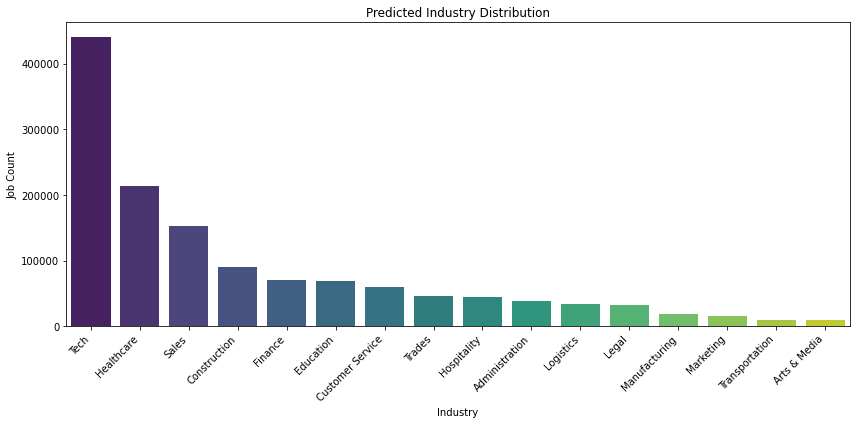

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


y_pred = pipeline.predict(p_df["job_title"])

# Create DataFrame of predictions
df_pred = pd.DataFrame({
    "job_title": p_df["job_title"],
    "predicted_industry": y_pred
})

# Count predictions per industry
industry_counts = df_pred["predicted_industry"].value_counts().reset_index()
industry_counts.columns = ["industry", "count"]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=industry_counts, x="industry", y="count", palette="viridis")
plt.title("Predicted Industry Distribution")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Job Count")
plt.xlabel("Industry")
plt.tight_layout()
plt.show()










############################################################################################################